In [131]:
from sklearn.neural_network import MLPRegressor
import numpy as np
import pandas as pd
import data_extraction
import ARIMA
from datetime import datetime
import matplotlib.pyplot as plt

In [132]:
def ANN_train(X_train, y_train, hidden_layers, alpha=1e-5, random_state=1):
    '''
    INPUT:
    timeseries: TYPE: DataFrame. Contains column named 'residual'
    q: TYPE: Integer. Decides how many historical values to consider
    hidden_layers: TYPE: Tuple of integers. The number on the i'th position decides number of nodes in hidden layer i

    OUTPUT:
    Returns trained model: TYPE: MLPRegressor
    '''
    model = MLPRegressor(solver="lbfgs", 
                         alpha=alpha, 
                         hidden_layer_sizes=hidden_layers, 
                         random_state=random_state, 
                         max_iter=20000,
                         tol=1e-4) #default tolerance
    model.fit(X_train, y_train)
    return model

In [133]:
past_vals = 40
nRowsRead = None
grid_number = 1


In [134]:


def data_ANN_train(past_vals):
    # input values
    # past_vals is the number of past values of the grid_loss that the ANN will use
    loss_series = data_extraction.get_timeseries("train", nRowsRead, 'loss', grid_number)
    load_series = data_extraction.get_timeseries("train", nRowsRead, 'load', grid_number)
    
    X = []
    y = []
    
    
    for i in range(len(loss_series) - past_vals - 1):
        X_el = loss_series[i:i+past_vals]
        
        t = datetime.strptime(loss_series.index[i+past_vals], "%Y-%m-%d %H:%M:%S")
        
        X_el_additional = []
        X_el_additional.append(t.hour)
        X_el_additional.append(t.month)

        # add the load of the predicted value
        X_el_additional.append(load_series[i+past_vals])
        
        X_el_additional = pd.Series(X_el_additional, name = X_el.name)

        df = pd.DataFrame(X_el.append(X_el_additional, ignore_index = True))
        nd = df.values

        nd_new = np.ndarray(shape=len(df.values))


        for j in range(len(nd)):
            nd_new[j] = nd[j,0]

        X.append(nd_new)
        y.append(loss_series[i + past_vals])
    
    return X, y


In [135]:
training_num = 24*4
X,y = data_ANN_train(past_vals)

print(X[0])




[ 18.766  18.02   18.246  18.645  19.823  23.797  29.153  30.826  30.551
  30.275  30.115  30.162  29.928  30.01   31.     31.071  30.341  29.032
  28.401  26.774  25.105  23.21   21.094  18.908  17.327  16.474  15.908
  15.743  15.725  16.165  17.24   18.928  20.891  22.304  22.569  22.096
  21.691  21.449  21.938  22.411  16.     12.    499.758]


In [136]:
model = ANN_train(X, y, (4))

In [137]:
def data_ANN_test(past_vals):
    loss_series_test = data_extraction.get_timeseries("test", nRowsRead, 'loss', grid_number)
    loss_series_train = data_extraction.get_timeseries("train", nRowsRead, 'loss', grid_number)
    load_series = data_extraction.get_timeseries("test", nRowsRead, 'load', grid_number)
        
    loss_series = loss_series_train[:-past_vals].append(loss_series_test)
    
    X = []
    
    for i in range(len(loss_series_test)):
        if i%24 == 0:
            X_el = loss_series[i:i+past_vals]
        
        #print(i)
        
        t = datetime.strptime(loss_series.index[i], "%Y-%m-%d %H:%M:%S")

        X_el_additional = []
        X_el_additional.append(t.hour)
        X_el_additional.append(t.month)

        # add the load of the predicted value
        X_el_additional.append(load_series[i])
        
        X_el_additional = pd.Series(X_el_additional, name = X_el.name)

        df = pd.DataFrame(X_el.append(X_el_additional, ignore_index = True))
        nd = df.values

        nd_new = np.ndarray(shape=len(df.values))


        for j in range(len(nd)):
            nd_new[j] = nd[j,0]


        X.append(nd_new)
        X_el = X_el[1:]
    
    
    return X
    

In [145]:
X_test = data_ANN_test(past_vals)

In [146]:
print(len(X_test))
print(len(data_extraction.get_timeseries("test", nRowsRead, 'loss', grid_number)))

4300
4300


In [147]:
def ANN_pred(model, X_test):
    X_test = X_test.copy()
    y_test = []
    for i in range(len(X_test)):
        X_test_el = X_test[i]
        X_test_losses = X_test_el[:-3]

        
        for j in range(i%24):
            y_test_el = np.ndarray(shape=1)
            v = y_test[- (i%24 - j)]
            y_test_el[0] = v
            X_test_losses = np.append(X_test_losses, y_test_el)

        X_test[i] = np.append(X_test_losses, X_test_el[-3:])
        
        
        val = model.predict([X_test[i]])

        y_test.append(val[0])
    return y_test



In [148]:
len(X_test)

4300

In [150]:
y_pred = ANN_pred(model, X_test)


In [105]:
len(y_pred)

4300

In [118]:
loss_series_test = data_extraction.get_timeseries("test", nRowsRead, 'loss', grid_number)

In [119]:
len(loss_series_test)

4300

In [120]:
df = pd.DataFrame(index=loss_series_test.index)

In [128]:
df["Pred"] = y_pred
df["Actual"] = loss_series_test.values
df["diff"] = df["Actual"]-df["Pred"]

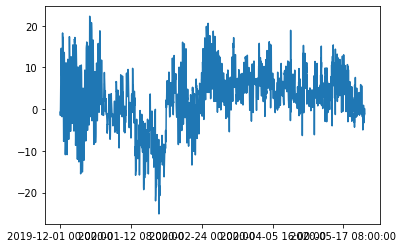

In [129]:
df["diff"].plot()